In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

# Define a simple neural network
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 75s 39ms/step - loss: 0.1522 - accuracy: 0.9526 - val_loss: 0.0562 - val_accuracy: 0.9825
Epoch 2/5
1875/1875 [==============================] - 76s 40ms/step - loss: 0.0492 - accuracy: 0.9846 - val_loss: 0.0296 - val_accuracy: 0.9902
Epoch 3/5
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0331 - accuracy: 0.9895 - val_loss: 0.0273 - val_accuracy: 0.9901
Epoch 4/5
1875/1875 [==============================] - 57s 31ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.0244 - val_accuracy: 0.9923
Epoch 5/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0326 - val_accuracy: 0.9909


In [ ]:
def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=50):
    """
    :param image: Input image
    :param model: Pretrained model
    :param num_classes: Number of classes
    :param overshoot: Used to create the adversarial example
    :param max_iter: Maximum number of iterations
    :return: Perturbation, number of iterations, perturbed image
    """
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    f_image = model(image)
    I = tf.argsort(f_image, axis=1, direction='DESCENDING')
    I = I[:, :num_classes]

    label = I[0, 0].numpy()

    input_shape = image.shape
    pert_image = image

    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    x = pert_image

    loop_i = 0

    while label == I[0, 0].numpy() and loop_i < max_iter:
        pert = np.inf
        gradients = []

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            fs = model(x)

        for k in range(1, num_classes):
            zero_gradients = np.zeros(input_shape)

            score_k = fs[0, I[0, k]]
            score_0 = fs[0, I[0, 0]]

            gradient_k = tape.gradient(score_k, x)
            gradient_0 = tape.gradient(score_0, x)

            w_k = gradient_k - gradient_0
            f_k = (score_k - score_0).numpy()

            pert_k = abs(f_k) / np.linalg.norm(w_k.numpy())

            if pert_k < pert:
                pert = pert_k
                w = w_k.numpy()

        r_i = (pert + 1e-4) * w / np.linalg.norm(w)

        r_tot = np.float32(r_tot + r_i)
        pert_image = image + (1 + overshoot) * r_tot

        x = tf.convert_to_tensor(pert_image, dtype=tf.float32)
        fs = model(x)
        loop_i += 1

        label = tf.argmax(fs[0]).numpy()

    r_tot = (1 + overshoot) * r_tot

    return r_tot, loop_i, pert_image


In [ ]:
def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=50):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    f_image = model(image)
    I = tf.argsort(f_image, axis=1, direction='DESCENDING')
    I = I[:, :num_classes]

    label = I[0, 0].numpy()

    input_shape = image.shape
    pert_image = image

    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    x = pert_image
    loop_i = 0

    while label == I[0, 0].numpy() and loop_i < max_iter:
        pert = np.inf

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            fs = model(x)
            label_score = fs[0, I[0, 0]]

        for k in range(1, num_classes):
            with tf.GradientTape() as tape_k:
                tape_k.watch(x)
                score_k = model(x)[0, I[0, k]]
                score_0 = label_score

            gradient_k = tape_k.gradient(score_k, x)
            gradient_0 = tape.gradient(score_0, x)

            if gradient_k is None or gradient_0 is None:
                continue

            w_k = gradient_k - gradient_0
            f_k = (score_k - score_0).numpy()

            pert_k = abs(f_k) / np.linalg.norm(w_k.numpy())

            if pert_k < pert:
                pert = pert_k
                w = w_k.numpy()

        r_i = (pert + 1e-4) * w / np.linalg.norm(w)

        r_tot = np.float32(r_tot + r_i)
        pert_image = image + (1 + overshoot) * r_tot

        x = tf.convert_to_tensor(pert_image, dtype=tf.float32)
        fs = model(x)
        loop_i += 1

        label = tf.argmax(fs[0]).numpy()

    r_tot = (1 + overshoot) * r_tot

    return r_tot, loop_i, pert_image


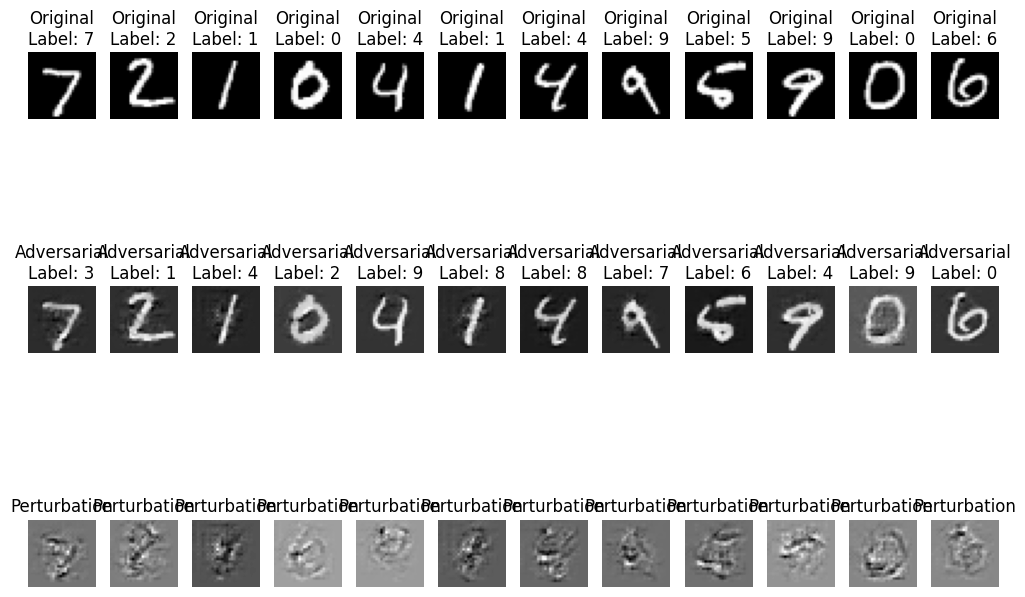

In [ ]:
# Test the DeepFool attack on a few examples
num_examples = 12
plt.figure(figsize=(10, 8))

for i in range(num_examples):
    original_image = test_images[i]
    label = test_labels[i]

    perturbation, num_iter, perturbed_image = deepfool(original_image, model)

    adv_label = tf.argmax(model(tf.convert_to_tensor(perturbed_image, dtype=tf.float32))[0]).numpy()

    plt.subplot(3, num_examples, i + 1)
    plt.imshow(original_image.squeeze(), cmap="gray")
    plt.title(f"Original\nLabel: {label}")
    plt.axis('off')

    plt.subplot(3, num_examples, num_examples + i + 1)
    plt.imshow(perturbed_image.numpy().squeeze(), cmap="gray")
    plt.title(f"Adversarial\nLabel: {adv_label}")
    plt.axis('off')

    plt.subplot(3, num_examples, 2 * num_examples + i + 1)
    plt.imshow(perturbation.squeeze(), cmap="gray")
    plt.title("Perturbation")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def generate_adversarial_dataset(images, labels, model, attack_method):
    adv_images = []
    adv_labels = []

    for i in range(len(images)):
        image = images[i]
        label = labels[i]

        perturbation, _, perturbed_image = attack_method(image, model)

        adv_images.append(perturbed_image.numpy().squeeze())
        adv_labels.append(label)

    return np.array(adv_images), np.array(adv_labels)

# Generate adversarial examples
adv_train_images, adv_train_labels = generate_adversarial_dataset(train_images, train_labels, model, deepfool)

# Combine original and adversarial examples
combined_train_images = np.concatenate((train_images, adv_train_images), axis=0)
combined_train_labels = np.concatenate((train_labels, adv_train_labels), axis=0)

# Retrain the model with combined dataset for additional 5 epochs
model.fit(combined_train_images, combined_train_labels, epochs=5, validation_data=(test_images, test_labels))

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy after adversarial training: {test_acc:.4f}")

# Evaluate the model on adversarial examples
adv_test_images, adv_test_labels = generate_adversarial_dataset(test_images, test_labels, model, deepfool)
adv_loss, adv_acc = model.evaluate(adv_test_images, adv_test_labels, verbose=2)
print(f"Test accuracy on adversarial examples: {adv_acc:.4f}")